# Plotting LLC curve experiments

In [38]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize

import json
import os
from datetime import datetime

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

pd.set_option('display.max_columns', 500)


import gen_commands_expt_llc_curve as gen_commands

In [318]:
# EXPT_NAME = "dev_202404251702"
# EXPT_NAME = "l2reg_202404271131"

# EXPT_NAME = "l2reg_202404272342" # actually it is varylr
# EXPT_NAME = "l2reg_202404272343" # actually it is varybatch

# EXPT_NAME = "varylr_202404290016"
# EXPT_NAME = "varybatch_202404290015"
# EXPT_NAME = "varybatch_epsilon_realisable_202404291728"
# EXPT_NAME = "varylr_epsilon_realisable_202404291729"

# EXPT_NAME = "sgld_sweep_202404292231"

# EXPT_NAME = "varybatch_202404301039"
# EXPT_NAME = "varylr_202404301039"

# EXPT_NAME = "varybatch_realisable_202404301617"
# EXPT_NAME = "varylr_realisable_202404301618"

# EXPT_NAME = "varylr_202404302210"
# EXPT_NAME = "varybatch_202404302211"
# EXPT_NAME = "varyl2reg_202404302212"

# EXPT_NAME = "varylr_202405011040"
# EXPT_NAME = "varybatch_202405011042"
# EXPT_NAME = "varyl2reg_202405011043"

# EXPT_NAME = "varylr_realisable_202405020033"
# EXPT_NAME = "varylr_realisable_202405020049"
# EXPT_NAME = "varybatch_realisable_202405020034"
# EXPT_NAME = "varybatch_realisable_202405020048"
# EXPT_NAME = "varyl2reg_realisable_202405020034"
# EXPT_NAME = "varyl2reg_realisable_202405020048"

# EXPT_NAME = "varylr_realisable_202405020816"
# EXPT_NAME = "varybatch_realisable_202405020817"
# EXPT_NAME = "varyl2reg_realisable_202405020817"

# EXPT_NAME = "varylr_202405022333" # In paper
# EXPT_NAME = "varybatch_202405022336" 
# EXPT_NAME = "varyl2reg_202405022357" # NO LONGER in paper

# EXPT_NAME = "varybatch_202405031202" # NO LONGER in paper

# EXPT_NAME = "varylr_realisable_fullbatch_202405041832"
# EXPT_NAME = "varybatch_realisable_fullbatch_202405041832"

# EXPT_NAME = "varylr_202405071236"
# EXPT_NAME = "varybatch_202405071237"

# EXPT_NAME = "varyl2reg_gcpaper_202405100815"
# EXPT_NAME = "varyl2reg_202405110010"            # In paper epsilon=5e-8
# EXPT_NAME = "varyl2reg_nomomentum_202405111027"
# EXPT_NAME = "varyl2reg_nomomentum_202405120959"
# EXPT_NAME = "varyl2reg_nomomentum_202405121134"     # In paper lr=0.001


# EXPT_NAME = "varybatch_sweeplr_202405101019"
EXPT_NAME = "varybatch_sweeplr_202405102358" # In paper lr=0.01, momentum=None

# EXPT_NAME = "varylabelnoise_202405131021"
# EXPT_NAME = "varylabelnoise_202405142218"

# EXPT_NAME = "varymomentum_202405150753"  # In paper

# EXPT_NAME = "varymodelsize_202405162250"
# EXPT_NAME = "varymodelsize_202405170728"
# EXPT_NAME = "varymodelsize_realisable_202405171529"
# EXPT_NAME = "varymodelsize_realisable_202405172107"
# EXPT_NAME = "varymodelsize_realisable_202405181104"
# EXPT_NAME = "varymodelsize_realisable_202405182024"
# EXPT_NAME = "varymodelsize_realisable_202405191244"
# EXPT_NAME = "varymodelsize_realisable_202405200805"
# EXPT_NAME = "varymodelsize_realisable_202405201425"

IMAGEDIR = f"./images/expt_llc_curve/{EXPT_NAME}"
DRYRUN = False
SUPTITLES = True
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9
os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath


def gen_axis_label(variable_name):
    yvar_label_map = {
        "lambdahat": "LLC Estimate",
        "lambdahat_with_burnin": "LLC Estimate",
        "lambdahat_with_burnin_minibatch": "LLC Estimate (minibatch initial loss)",
        "t": "Iteration",
        "train_loss": "Train Loss",
        "test_loss": "Test Loss",
        "train_accuracy": "Train Accuracy",
        "test_accuracy": "Test Accuracy",
        "training_config.learning_rate": "Learning Rate",
        "training_config.batch_size": "Batch Size",
        "training_config.momentum": "Momentum",
        "training_config.l2_regularization": "$L^2$-regularization",
        "sgld_config.epsilon": "SGLD Step Size",
        "sgld_config.batch_size": "SGLD Batch Size",
        "model_data_config.layer_width_factor": "$k$",   
    }
    return yvar_label_map.get(variable_name, variable_name)

def get_color_palette(hue_var, use_default=False):
    color_mapping = {
        "training_config.learning_rate": "viridis",
        "training_config.batch_size": "flare_r", # reversed since lower batch size, higher regularization
        "training_config.momentum": "magma",
        "training_config.l2_regularization": "mako",
        "model_data_config.layer_width_factor": "rocket",
    }
    if use_default:
        if hue_var == "training_config.batch_size":
            return "flare_r"
        else:
            return "flare"
    return color_mapping.get(hue_var, "flare")

def _filter_df_data(df_data, filters):
    df = df_data.copy(deep=True)
    for key, val in filters.items():
        if val is None:
            df = df[df[key].isna()]
        else:
            df = df[df[key] == val]
    return df


def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


def extract_data(subdir):
    with open(os.path.join(subdir, 'run.json'), 'r') as f:
        run = json.load(f)

    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    subdir_id = int(os.path.basename(subdir))
    doc = {"config": config, "info": info}
    data = []
    for x in info:
        sgld_completed = (len(x.get('loss_trace', [])) == config.get('sgld_config', {}).get('num_steps'))
        start_time = run.get('start_time')
        stop_time = run.get('stop_time')
        if start_time and stop_time:
            parsed_time_taken = datetime.strptime(stop_time, "%Y-%m-%dT%H:%M:%S.%f") - datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S.%f")
            parsed_time_taken = parsed_time_taken.total_seconds()
        else:
            parsed_time_taken = None

        extracted_info = {
            "_id": subdir_id,
            "status": run.get('status'),
            "time_taken": parsed_time_taken,
            "expt_name": config.get('expt_name'),
            "force_realisable": config.get('force_realisable'),
            "loss_trace_minibatch": config.get('loss_trace_minibatch'),
            "seed": config.get('seed'),
            "sgld_completed": sgld_completed,

            "t": x.get('t'),
            "lambdahat": x.get('lambdahat'),
            "loss_trace": x.get('loss_trace'),
            "init_loss": x.get('init_loss'),
            "test_accuracy": x.get('test_accuracy'),
            "train_accuracy": x.get('train_accuracy'),
            "train_loss": x.get('train_loss'),
        }
        for key, val in config.get('sgld_config', {}).items():
            extracted_info[f"sgld_config.{key}"] = val
        
        for key, val in config.get('training_config', {}).items():
            extracted_info[f"training_config.{key}"] = val
        
        for key, val in config.get('model_data_config', {}).items():
            extracted_info[f"model_data_config.{key}"] = val
        
        for key in ["test_loss", "test_loss_no_reg"]: # backward compatibility purpose
            if key in x:
                extracted_info[key] = x[key]

        data.append(extracted_info)
    return data, doc

def extract_directory(directory_path):
    all_data = []

    for subdir in os.listdir(directory_path):
        full_subdir_path = os.path.join(directory_path, subdir)
        if subdir == "_sources" or not os.path.isdir(full_subdir_path):
            continue
        if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
            try: 
                data, doc = extract_data(full_subdir_path)
                all_data += data
                sample_doc = doc
            except Exception as e:
                print("ERROR: ", full_subdir_path)
                print(e)
    return all_data, sample_doc

def postprocess_df(df_data):
    df_data["first_nan_index"] = [
        list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
        for trace in df_data["loss_trace"]
    ]

    results = []
    results2 = []
    results_wbic = []
    n = 50000 # TODO: hard coded CIFAR10 training data size
    for _, row in df_data.iterrows():
        losses = row["loss_trace"]
        init_loss = row["init_loss"]
        burn_in = int(BURN_IN_PROP * len(losses))
        wbic = n * np.mean(losses[burn_in:])
        lambdahat_burnin = (np.mean(losses[burn_in:]) - init_loss) * n / np.log(n)
        lambdahat_burnin_minibatch = (np.mean(losses[burn_in:]) - losses[0]) * n / np.log(n)
        results.append(lambdahat_burnin)
        results2.append(lambdahat_burnin_minibatch)
        results_wbic.append(wbic)
    df_data["lambdahat_with_burnin"] = results
    df_data["lambdahat_with_burnin_minibatch"] = results2
    df_data["wbic"] = results_wbic
    return df_data


directory_path = f"./spartan_outputs/expt_llc_curve_outputs/{EXPT_NAME}"
all_data, sample_doc = extract_directory(directory_path)
df_data = pd.DataFrame(all_data)
print(df_data["sgld_completed"].value_counts())
print(df_data.groupby("_id").aggregate({"status": "unique"}).reset_index()["status"].value_counts())
df_data = df_data[df_data["status"] == "COMPLETED"]
df_data = postprocess_df(df_data)

# df_data.head()

sgld_completed
True    6166
Name: count, dtype: int64
status
[COMPLETED]    144
[RUNNING]       13
Name: count, dtype: int64


In [309]:
# print out unique values for each config key
df = df_data
other_keys = [
    "model_data_config.label_noise_level", 
    "model_data_config.layer_width_factor", 
    "force_realisable", 
    "loss_trace_minibatch", 
    "seed"
]
keys = (
    [f"sgld_config.{k}" for k in sample_doc["config"].get("sgld_config", {}).keys()]
    + [f"training_config.{k}" for k in sample_doc["config"].get("training_config", {}).keys()]
    + other_keys
)

for key in keys:
    if key not in df.columns:
        continue
    items = df[key].unique()
    if len(items) == 1:
        items = items[0]
    print(f"{key:36s}: {items}")
print()

import json
print(json.dumps(sample_doc["config"], indent=2))

sgld_config.batch_size              : 2048
sgld_config.epsilon                 : 2e-07
sgld_config.gamma                   : 1.0
sgld_config.num_chains              : 1
sgld_config.num_steps               : 3000
training_config.batch_size          : [  32   64  256  128   16 1024  512    8]
training_config.l2_regularization   : None
training_config.learning_rate       : [0.01  0.005]
training_config.momentum            : [0.9 nan]
training_config.num_steps           : 100001
training_config.optim               : sgd
force_realisable                    : False
loss_trace_minibatch                : True
seed                                : [4 1 3 0 2]

{
  "do_plot": false,
  "expt_name": "varybatch_sweeplr_202405102358",
  "force_realisable": false,
  "logging_period": 2500,
  "loss_trace_minibatch": true,
  "model_data_config": {
    "data_name": "cifar10",
    "model_name": "resnet18"
  },
  "seed": 4,
  "sgld_config": {
    "batch_size": 2048,
    "epsilon": 2e-07,
    "gamma": 1.0,

(713, 33)
sgd-None-512-None-0.9
expt_name: varylr_202405022333, sgld_config.epsilon: 2e-07, sgld_config.gamma: 1.0, sgld_config.num_steps: 3000
sgld_config.batch_size: 2048, loss_trace_minibatch: True, training_config.optim: sgd, training_config.momentum: 0.9
training_config.num_steps: 30001, training_config.learning_rate: [0.2   0.01  0.005 0.1   0.05 ], training_config.batch_size: 512, training_config.l2_regularization: None
force_realisable: False, seed: [4 1 3 2 0], 
Saving file at: ./images/expt_llc_curve/varylr_202405022333/varylr_202405022333_sgd-None-512-None-0.9_llc_curve_maintext.pdf


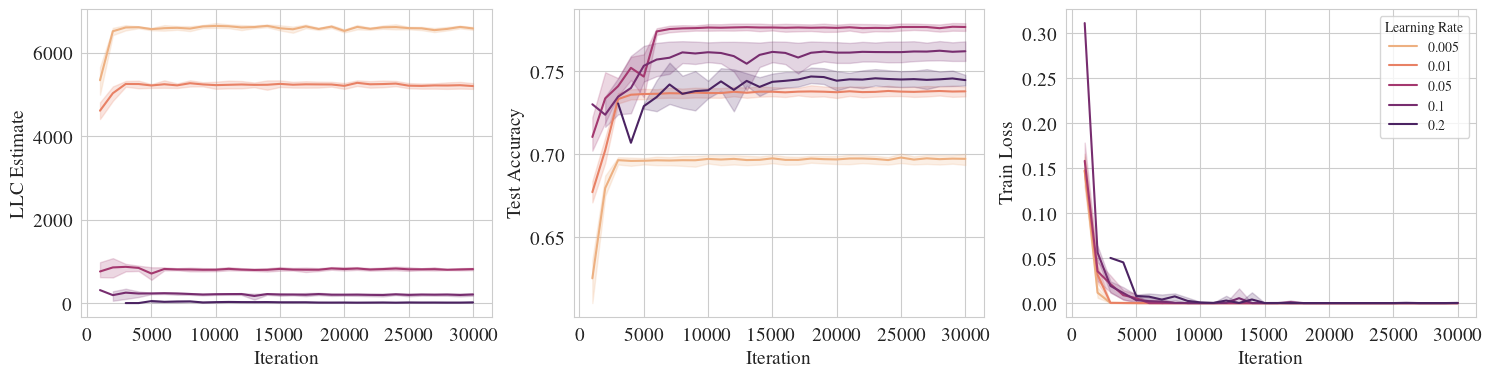

In [301]:

filters = {
    "sgld_config.batch_size": 2048,
    "sgld_config.epsilon": 2e-7,
    "training_config.batch_size": 512,
    # "training_config.l2_regularization": None,
    # "training_config.learning_rate": 0.8,
    "training_config.momentum": .9,
    "training_config.optim": "sgd",
    # "model_data_config.label_noise_level": None,
    "force_realisable": False,
    # "seed": 0,
}
hue_var = "training_config.learning_rate"
# hue_var = "training_config.batch_size"
# hue_var = "training_config.l2_regularization"
# hue_var = "training_config.momentum"
# hue_var = "model_data_config.label_noise_level"
# hue_var = "model_data_config.layer_width_factor"

palette = get_color_palette(hue_var, use_default=True)

df = _filter_df_data(df_data, filters)


df = df[df["t"] > 100]
df = df[df["lambdahat_with_burnin"] >= 0]
# df[yvar_name] = np.clip(df["lambdahat_with_burnin"], -0, 1e4)
# df = df[df["lambdahat_with_burnin"] < 10e6]
print(df.shape)

yvars = [
    "lambdahat_with_burnin", 
    # "lambdahat_with_burnin_minibatch",
    "test_accuracy",
    # "train_accuracy",
    # "test_loss",
    # "test_loss_no_reg", 
    "train_loss",
]
log_hue_vars = [
    "training_config.learning_rate",
    "training_config.batch_size", 
    "model_data_config.layer_width_factor"
]
ncols = 3
nrows = len(yvars) // ncols + int(len(yvars) % ncols > 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharex=True)
axes = axes.flatten()
for i, (ax, yvar_name) in enumerate(zip(axes, yvars)):
    sns_plot = sns.lineplot(
        data=df, 
        x="t", 
        y=yvar_name, 
        hue=hue_var, 
        # legend="full",
        legend="full" if i == len(yvars) - 1 else None, 
        ax=ax, 
        errorbar=("ci", 95), 
        hue_norm=mpl.colors.LogNorm() if hue_var in log_hue_vars else None,
        palette=palette
    )
    
    ax.set_ylabel(gen_axis_label(yvar_name))
    ax.set_xlabel(gen_axis_label("t"))
    # ax.set_yscale("log")
handles, labels = sns_plot.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title=gen_axis_label(hue_var), loc="upper right")



optim_config = f"{filters['training_config.optim']}"
for key in ["training_config.learning_rate", "training_config.batch_size", "training_config.l2_regularization", "training_config.momentum"]:
    if key in filters:
        optim_config += f"-{filters[key]}"
    else:
        optim_config += "-None"
print(optim_config)


line_break_counter = 0
entry_per_line = 4
title_str = ""
for key in gen_commands.config.keys():
    if key in df.columns:
        vals = df[key].unique()
        if len(vals) > 1:
            title_str += f"{key}: {vals}"
        else:
            title_str += f"{key}: {vals[0]}"
        line_break_counter += 1
        if line_break_counter % entry_per_line == 0:
            title_str += "\n"
        else:
            title_str += ", "
print(title_str)
if SUPTITLES:
    # fig.suptitle(title_str, fontsize="small")
    pass
# savefig_fn(fig, f"{EXPT_NAME}_{optim_config}_llc_curve.pdf")
savefig_fn(fig, f"{EXPT_NAME}_{optim_config}_llc_curve_maintext.pdf")

(18, 35)
Number of unique ids: 18. IDs: [ 58  60 116 118  80  75  86  72 110  88  62 108  64  79 112  70  76 114]


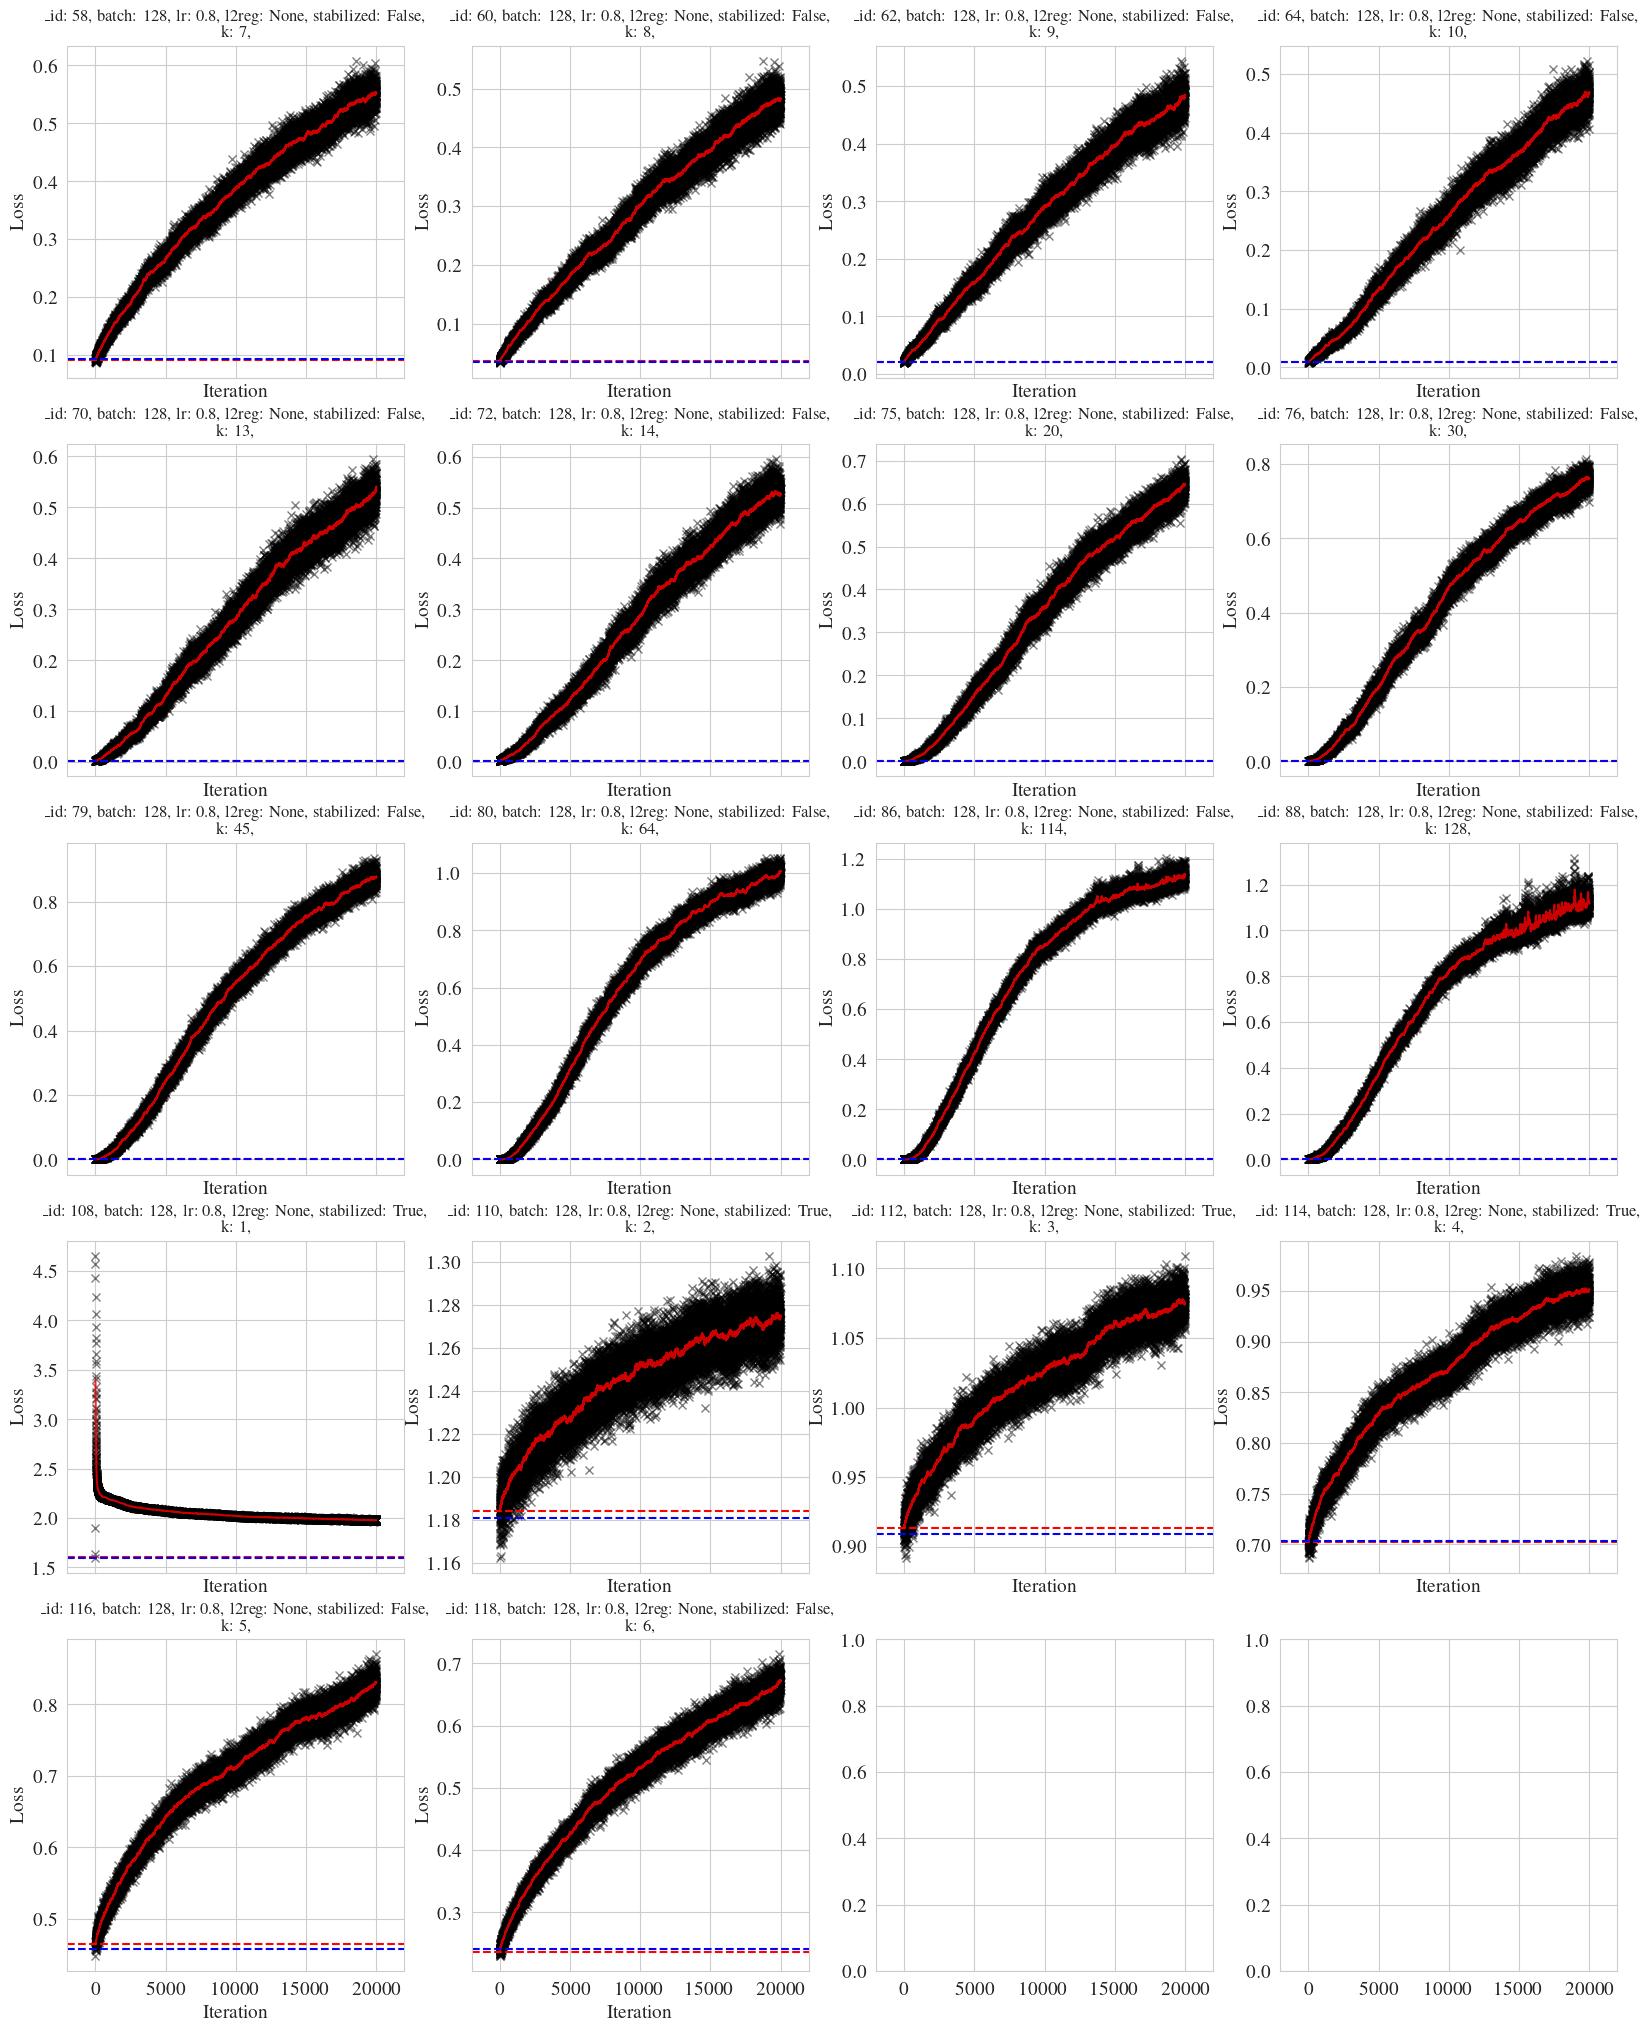

In [292]:

def running_mean(data, window_size=10):
    if window_size % 2 == 0:
        left_pad = window_size // 2
        right_pad = window_size // 2 - 1
    else:
        left_pad = right_pad = window_size // 2

    # Reflect the data for boundary cases
    pad_left = data[:left_pad][::-1]
    pad_right = data[-right_pad:][::-1]
    padded_data = np.concatenate([pad_left, data, pad_right])

    kernel = np.ones(window_size) / window_size
    return np.convolve(padded_data, kernel, mode='valid')

def loss_trace_has_stabilized(loss_trace, ratio_threshold=0.10, num_steps=50, window_size=50):
    if len(loss_trace) < num_steps:
        return False
    loss_trace_running_mean = running_mean(loss_trace, window_size=window_size)
    tail_average_loss = np.mean(loss_trace_running_mean[-num_steps:])
    percent_variation = np.abs(loss_trace_running_mean - tail_average_loss) / tail_average_loss
    return np.average(percent_variation) < ratio_threshold


df = _filter_df_data(df_data, filters)
df = df[
    (df["t"] == df["t"].max())
    & (df["seed"] == df["seed"].max())
]
print(df.shape)
unique_ids = df["_id"].unique()
print(f"Number of unique ids: {len(unique_ids)}. IDs: {unique_ids}")
num_plots = min(24, len(unique_ids))
rand_ids = sorted(np.random.choice(unique_ids, num_plots, replace=False))

num_cols = 4
num_rows = num_plots // num_cols + int(num_plots % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharex=True, sharey=False)
for idx, ax in zip(rand_ids, axes.flat):
    row = df[df["_id"] == idx]
    loss_trace = row["loss_trace"].iloc[0]
    # loss_trace = np.clip(loss_trace, -1e3, 3)
    ax.plot(loss_trace, "kx", alpha=0.5)
    ax.plot(running_mean(loss_trace, window_size=50), "r-", alpha=0.8)
    ax.set_xlim(-len(loss_trace) / 10, len(loss_trace) * 1.1)
    ax.set_title(
        f"_id: {idx}, "
        f"batch: {row['training_config.batch_size'].item()}, "
        f"lr: {row['training_config.learning_rate'].item()}, "
        f"l2reg: {row['training_config.l2_regularization'].item()}, "
        f"stabilized: {loss_trace_has_stabilized(loss_trace)},\n"
        f"k: {row['model_data_config.layer_width_factor'].item()}, "
    )
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    xmin, xmax = ax.get_xlim()
    ax.hlines(row["init_loss"].iloc[0], xmin, xmax, color="r", linestyle="--")
    ax.hlines(loss_trace[0], xmin, xmax, color="b", linestyle="--")
    # ax.set_yscale("log")


Text(0.5, 1.0, 'LLC vs Test Loss')

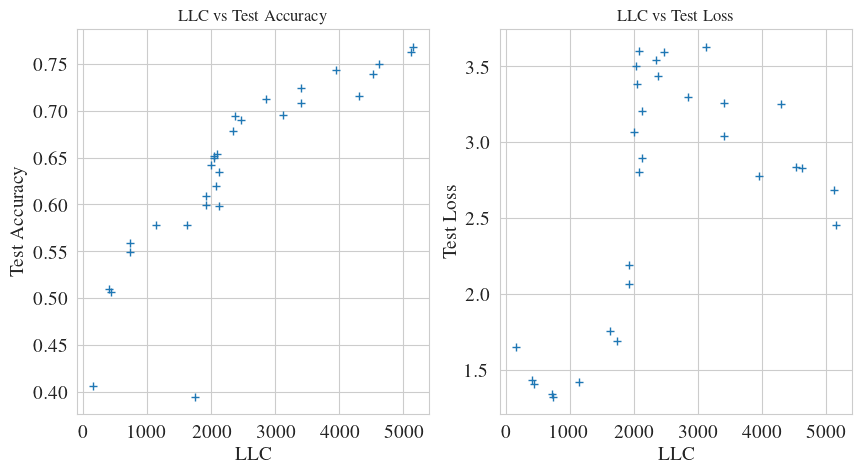

In [293]:
df = _filter_df_data(df_data, filters)
df = df[
    # (df["t"] > 10000)
    (df["t"] == df["t"].max())  # only take the last iteration
    # & (df["training_config.batch_size"] > 100)
    # & (df["lambdahat_with_burnin"] > 0)
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.plot(df["lambdahat_with_burnin"], df["test_accuracy"], "+")
ax.set_xlabel("LLC")
ax.set_ylabel("Test Accuracy")
ax.set_title("LLC vs Test Accuracy")

ax = axes[1]
ax.plot(df["lambdahat_with_burnin"], df["test_loss"], "+")
ax.set_xlabel("LLC")
ax.set_ylabel("Test Loss")
ax.set_title("LLC vs Test Loss")


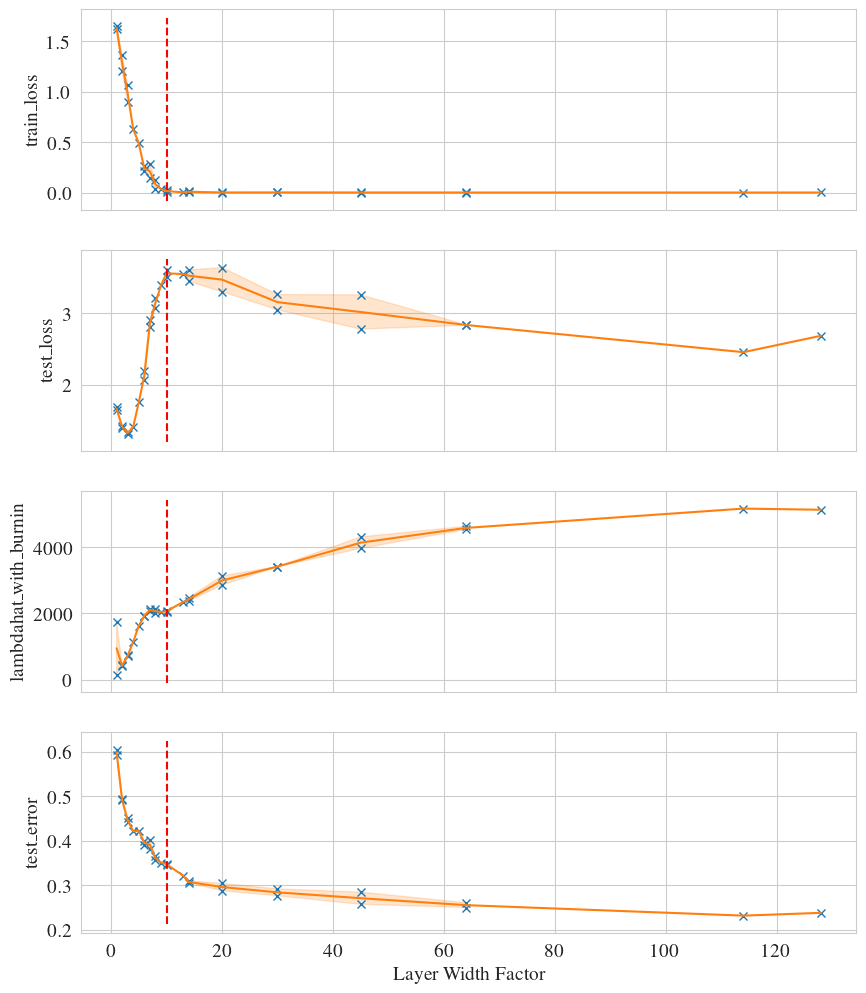

In [294]:
df = _filter_df_data(df_data, filters)
df = df[
    (df["t"] == df["t"].max())
]
df["test_error"] = 1 - df["test_accuracy"]
yvars = ["train_loss", "test_loss", "lambdahat_with_burnin", "test_error"]

fig, axes = plt.subplots(len(yvars), 1, figsize=(10, 3 * len(yvars)), sharex=True)
for i, yvar_name in enumerate(yvars):
    ax = axes[i]
    ax.plot(df["model_data_config.layer_width_factor"], df[yvar_name], "x")
    sns.lineplot(data=df, x="model_data_config.layer_width_factor", y=yvar_name, ax=ax, errorbar=("ci", 95))
    ax.set_xlabel("Layer Width Factor")
    ax.vlines(10, *ax.get_ylim(), color="r", linestyle="--")
    # ax.set_xscale("log")


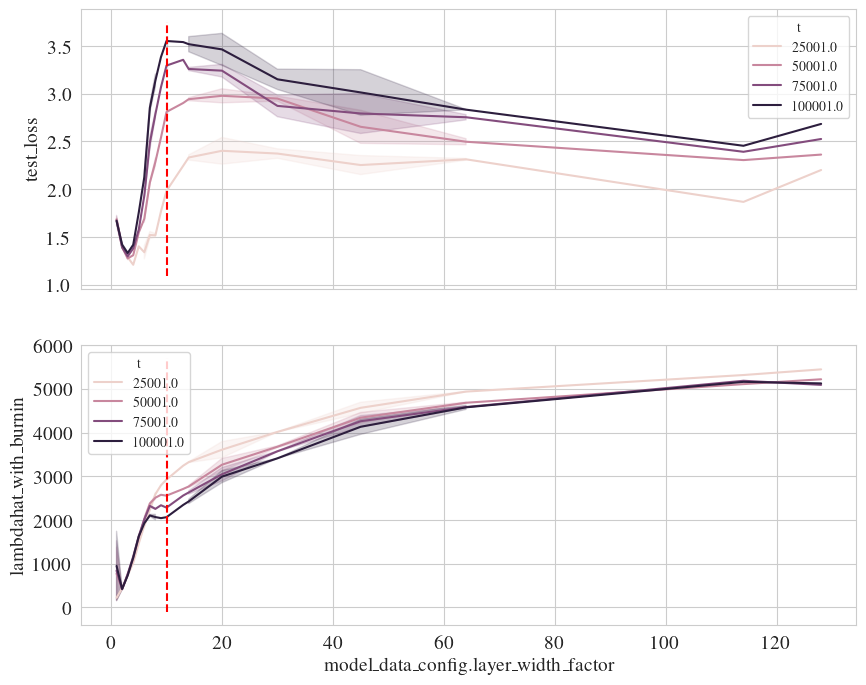

In [295]:
df = _filter_df_data(df_data, filters)
df = df[df["t"] > 100]
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


ax = axes[0]
sns.lineplot(
    data=df, 
    x="model_data_config.layer_width_factor",
    y="test_loss", 
    hue="t", 
    legend="full",
    ax=ax, 
    errorbar=("ci", 95), 
)
ax.vlines(10, *ax.get_ylim(), color="r", linestyle="--")

ax = axes[1]
sns.lineplot(
    data=df, 
    x="model_data_config.layer_width_factor",
    y="lambdahat_with_burnin", 
    hue="t", 
    legend="full",
    ax=ax, 
    errorbar=("ci", 95), 
)
ax.vlines(10, *ax.get_ylim(), color="r", linestyle="--")


Saving file at: ./images/expt_llc_curve/varymodelsize_realisable_202405201425/varymodelsize_realisable_202405201425_sgd-0.8-None-None-None_llc_vs_layer_width_t100001.0.pdf


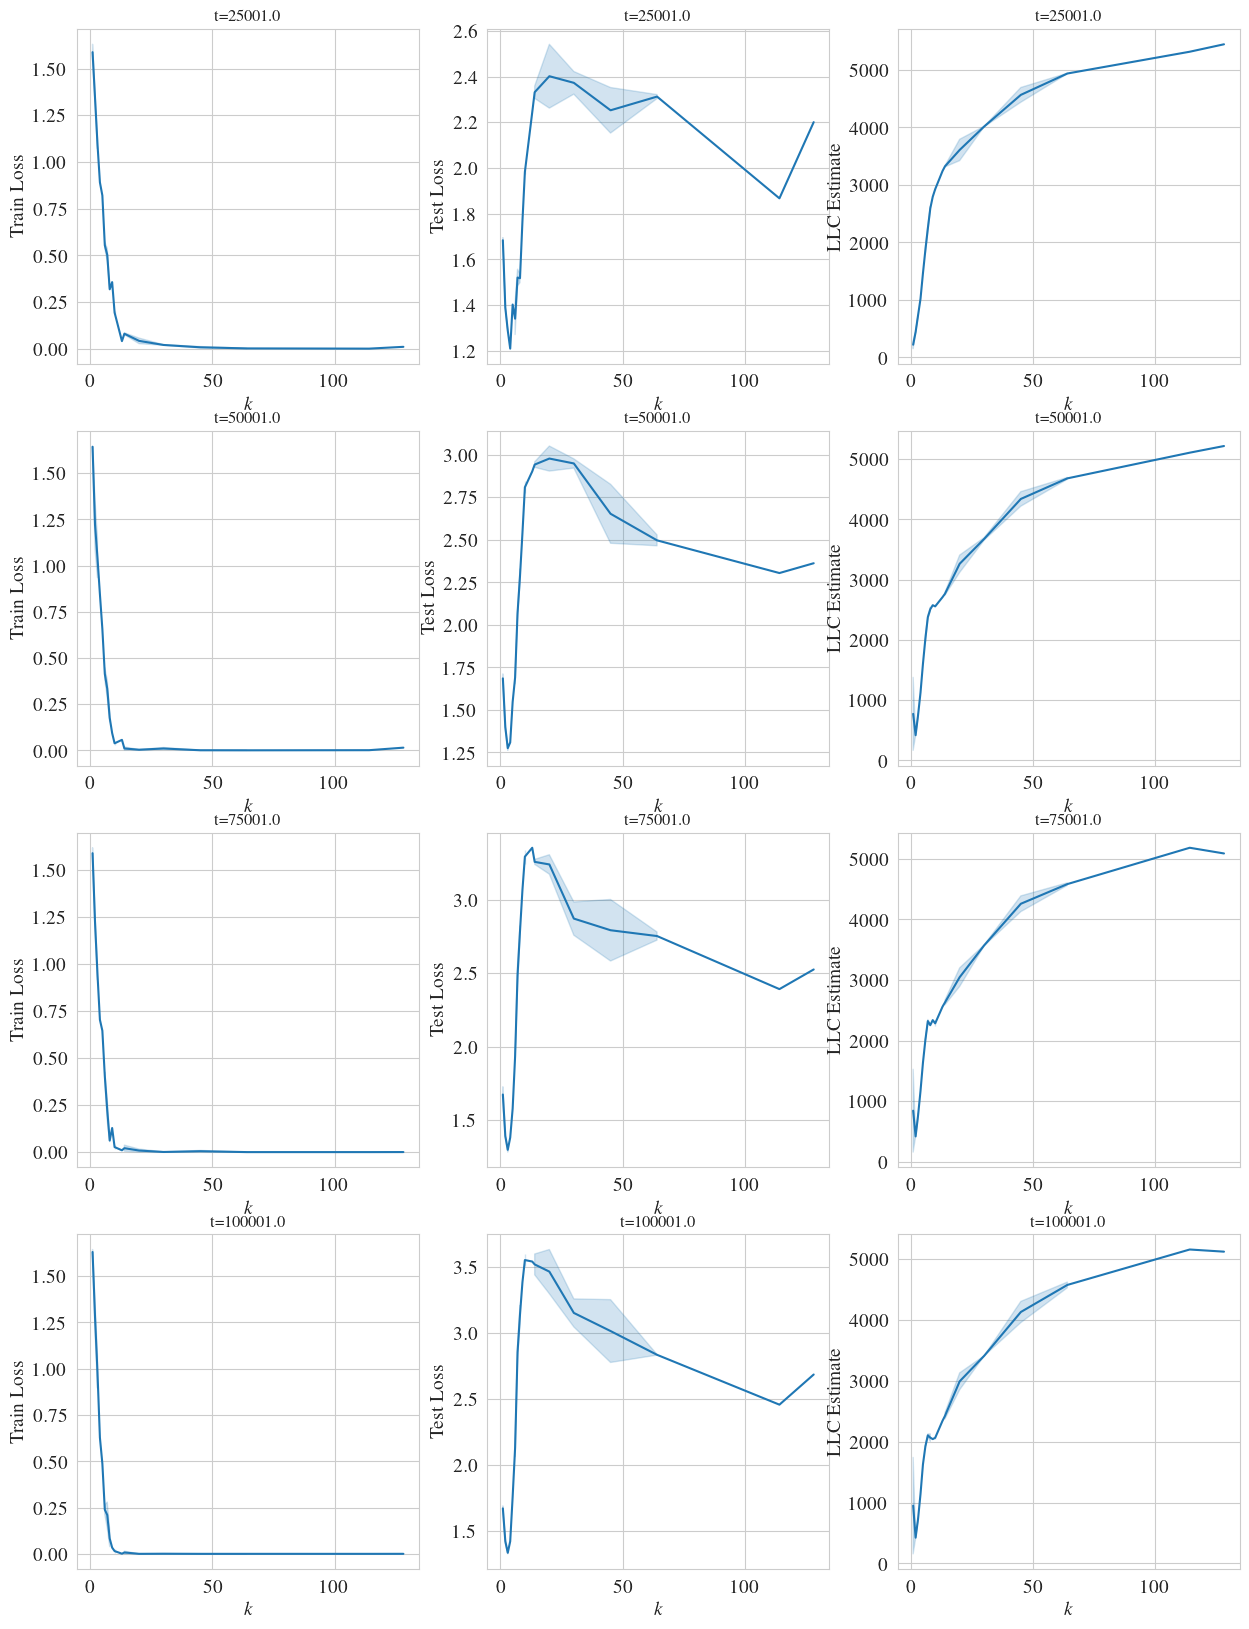

In [296]:
keys = [
    "train_loss",
    "test_loss",
    "lambdahat_with_burnin",
]
iterations = sorted(df["t"].unique())
fig, axes = plt.subplots(len(iterations), len(keys), figsize=(5 * len(keys), 5 * len(iterations)))

for i, t in enumerate(iterations):
    df_t = df[df["t"] == t]
    for j, key in enumerate(keys):
        ax = axes[i, j]
        sns.lineplot(
            data=df_t, 
            x="model_data_config.layer_width_factor",
            y=key, 
            ax=ax, 
            errorbar=("ci", 95), 
        )
        ax.set_xlabel(gen_axis_label("model_data_config.layer_width_factor"))
        ax.set_ylabel(gen_axis_label(key))
        ax.set_title(f"t={t}")
savefig_fn(fig, f"{EXPT_NAME}_{optim_config}_llc_vs_layer_width_t{t}.pdf")